In [97]:
# Install required packages
#!pip install matplotlib rustworkx numpy scipy
#!pip install qiskit qiskit-ibm-runtime
#!pip install pylatexenc
#!pip install qiskit-aer

In [98]:
import matplotlib
import matplotlib.pyplot as plt
import rustworkx as rx
import networkx as nx
from rustworkx.visualization import mpl_draw as draw_graph
import math
import itertools
import numpy as np
from scipy.optimize import minimize
from collections import defaultdict
from typing import Sequence


from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [99]:
# Step 1: Data & corrected haversine
hospital = {"name": "Central Hospital", "lat": 29.99512653425452, "lon": 31.68462840171934}

patients = [
    {"id": "DT",   "lat": 30.000417586266437, "lon": 31.73960813272627},
    {"id": "GR",   "lat": 30.011344405285193, "lon": 31.747827362371993},
    {"id": "R2",   "lat": 30.030388325206854, "lon": 31.669231198639675},
    {"id": "R3_2", "lat": 30.030940768851426, "lon": 31.688371339937028},
    {"id": "IT",   "lat": 30.01285635906825,  "lon": 31.693811715848444},
]

def haversine(coord1, coord2):
    """Return haversine distance (km) between coord1=(lat,lon) and coord2=(lat,lon)."""
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    phi1 = math.radians(lat1); phi2 = math.radians(lat2)
    dphi = phi2 - phi1
    dlambda = math.radians(lon2) - math.radians(lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1) * math.cos(phi2) * math.sin(dlambda/2)**2
    R = 6371.0
    return 2.0 * R * math.asin(math.sqrt(a))

In [100]:
# Step 2: distance tables
patient_ids = [p["id"] for p in patients]
coords = {p["id"]: (p["lat"], p["lon"]) for p in patients}
coords["H"] = (hospital["lat"], hospital["lon"])  # 'H' for hospital

# hospital -> patient distances
d_h = {pid: haversine(coords["H"], coords[pid]) for pid in patient_ids}

# patient -> patient distances
d = {}
for a in patient_ids:
    for b in patient_ids:
        d[(a, b)] = haversine(coords[a], coords[b])

# quick check
print("H -> DT (km):", d_h["DT"])
print("DT -> GR (km):", d[("DT","GR")])

H -> DT (km): 5.327124952664338
DT -> GR (km): 1.4500439631084925


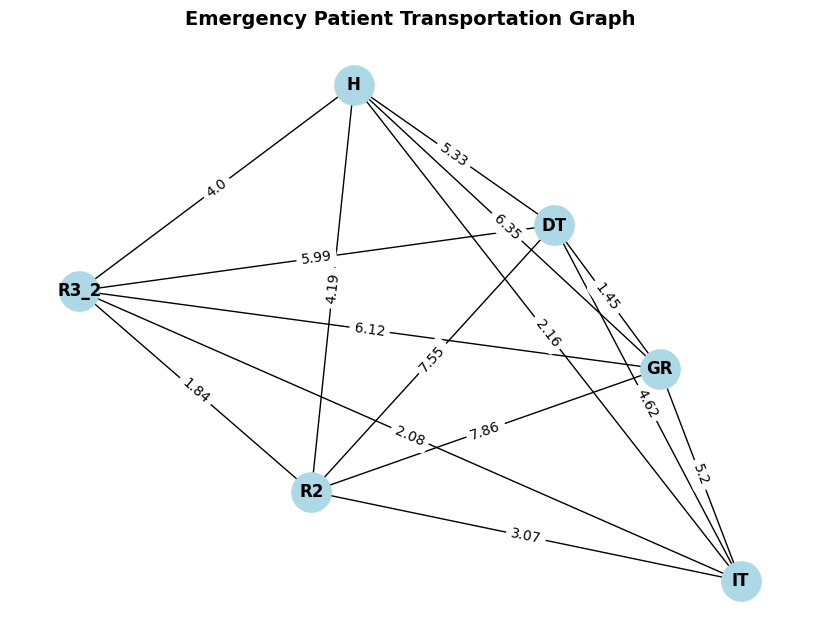

In [101]:
# --- create graph for visualisation ---
G = nx.Graph()

# build edge list
edge_list_id = []

# add patient-patient edges (avoid duplicates + no self-loops)
for (u, v), w in d.items():
    if u < v and w > 0:
        edge_list_id.append((u, v, round(w, 2)))  # round weight here

# add hospital-patient edges
for p, w in d_h.items():
    edge_list_id.append(("H", p, round(w, 2)))  # round weight here too

# add edges to graph
for u, v, w in edge_list_id:
    G.add_edge(u, v, weight=w)

# --- layout & drawing ---
pos = nx.spring_layout(G, seed=42)  # fixed seed for consistent layout
plt.figure(figsize=(8, 6))
nx.draw(G, pos,with_labels=True,node_size=800,node_color="lightblue",font_size=12,font_weight="bold")

# edge labels (weights)
labels = nx.get_edge_attributes(G, "weight")
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_size=10)

plt.title("Emergency Patient Transportation Graph", fontsize=14, fontweight="bold")
plt.show()

{'H': 0, 'DT': 1, 'GR': 2, 'R2': 3, 'R3_2': 4, 'IT': 5}


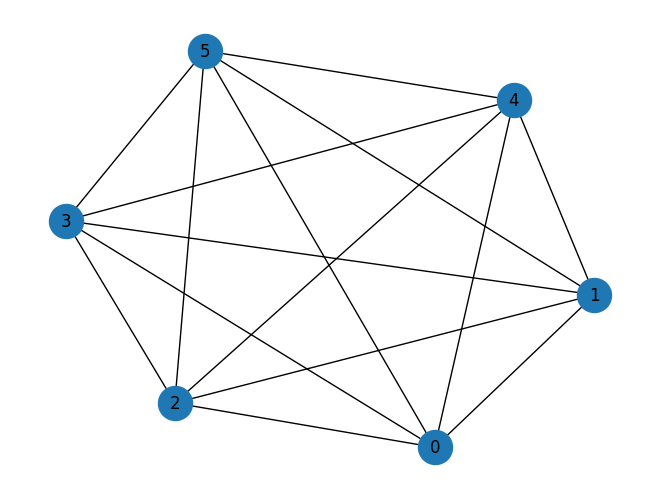

In [102]:
# define nodes: Assign each node an index
nodes = ["H"] + patient_ids

# mapping: label -> index
node_index = {label: i for i, label in enumerate(nodes)}

# create graph
graph = rx.PyGraph()
graph.add_nodes_from(range(len(nodes)))  # integers only

edge_list = []

# patient-patient edges
for (u, v), w in d.items():
    if u < v:
        edge_list.append((node_index[u], node_index[v], w))

# hospital-patient edges
for p, w in d_h.items():
    edge_list.append((node_index["H"], node_index[p], w))

graph.add_edges_from(edge_list)

# draw with labels
print(node_index)
draw_graph(graph, node_size=600, with_labels=True)

In [103]:
# step 2: Map the graph (classical problem) to QUBO notation / to Quantum problem directly
# step 2.1: the cost function Hamiltonian: contains the quantum definition of our problem
n = 6
def build_max_cut_paulis(graph: rx.PyGraph) -> list[tuple[str, float]]:
    """Convert the graph to Pauli list.

    This function does the inverse of `build_max_cut_graph`
    """
    pauli_list = []
    for edge in list(graph.edge_list()):
        weight = graph.get_edge_data(edge[0], edge[1])
        pauli_list.append(("ZZ", [edge[0], edge[1]], weight))
    return pauli_list


max_cut_paulis = build_max_cut_paulis(graph)
cost_hamiltonian = SparsePauliOp.from_sparse_list(max_cut_paulis, n)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIZZI', 'IIZIZI', 'IZIIZI', 'ZIIIZI', 'IIZZII', 'IZIZII', 'ZIIZII', 'IZZIII', 'ZIZIII', 'ZZIIII', 'IIIIZZ', 'IIIZIZ', 'IIZIIZ', 'IZIIIZ', 'ZIIIIZ'],
              coeffs=[1.45004396+0.j, 7.55125414+0.j, 5.98797741+0.j, 4.6216128 +0.j,
 7.85774479+0.j, 6.12496477+0.j, 5.20366098+0.j, 1.84360417+0.j,
 3.0660853 +0.j, 2.07798997+0.j, 5.32712495+0.j, 6.34727812+0.j,
 4.19184753+0.j, 3.99863485+0.j, 2.16070811+0.j])


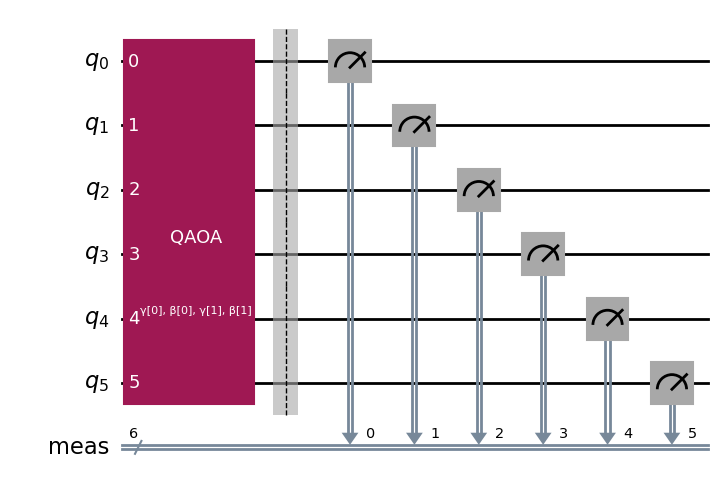

In [104]:
# step 2.2: Create a quantum circuit which will prepare the ground state of our Hamiltonian
circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=2)
circuit.measure_all()

circuit.draw("mpl")

AerSimulator('aer_simulator')


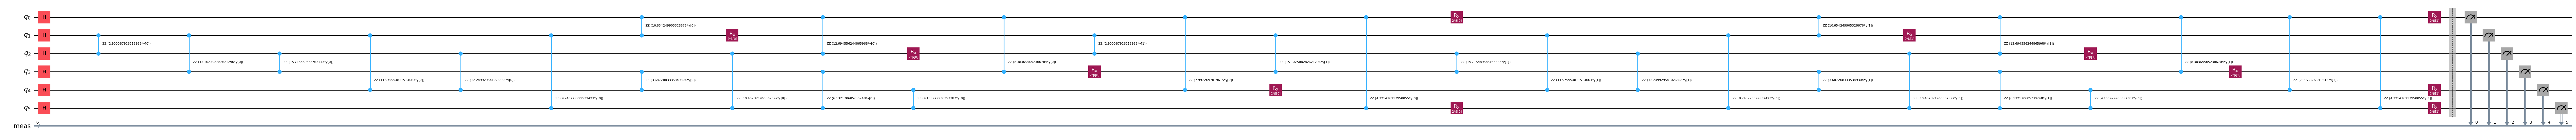

In [105]:
backend = AerSimulator()

print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

candidate_circuit = pm.run(circuit)
candidate_circuit.draw("mpl", fold=False, idle_wires=False)

In [106]:
# Step 3: optimize QAOA parameters

initial_gamma = np.pi
initial_beta = np.pi / 2
init_params = [initial_beta, initial_beta, initial_gamma, initial_gamma]

def cost_func_estimator(params, ansatz, hamiltonian, estimator):
    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)

    return cost

In [107]:
objective_func_vals = []  # Global variable
with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, cost_hamiltonian, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

 message: Return from COBYLA because the trust region radius reaches its lower bound.
 success: True
  status: 0
     fun: -4.412522812463138
       x: [ 2.320e+00  1.691e+00  2.964e+00  4.230e+00]
    nfev: 27
   maxcv: 0.0


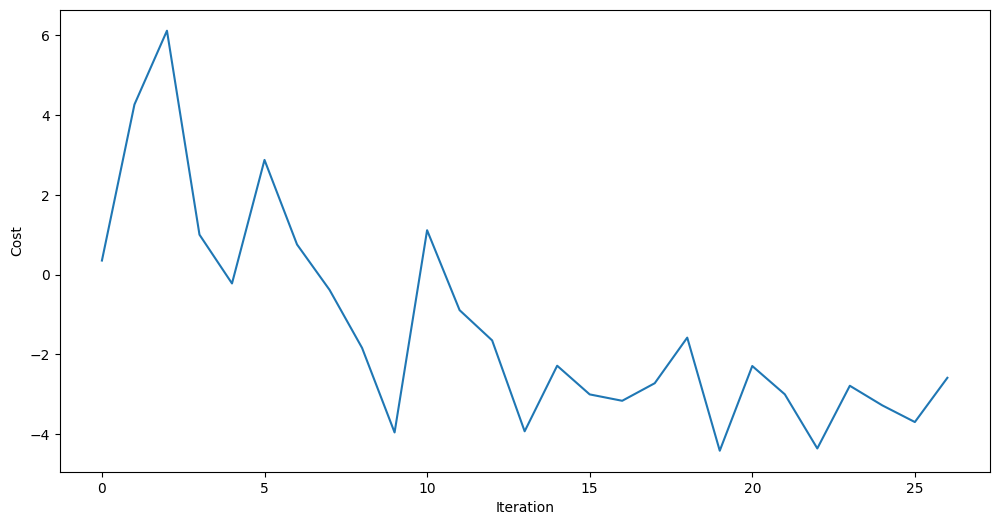

In [108]:
plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

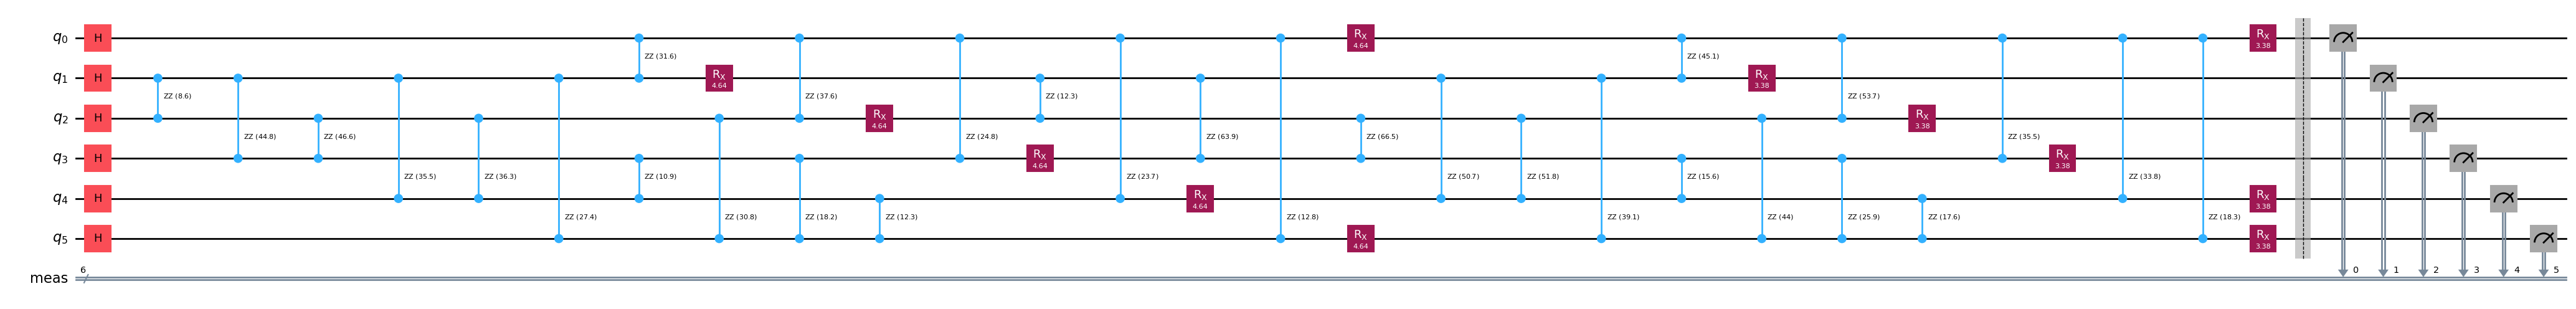

In [109]:
# step 4: sample the final distribution obtained with the optimized parameters
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw("mpl", fold=False, idle_wires=False)

In [110]:
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

pub = (optimized_circuit,)
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val / shots for key, val in counts_int.items()}
final_distribution_bin = {key: val / shots for key, val in counts_bin.items()}
print(final_distribution_int)

{46: 0.0172, 35: 0.0461, 55: 0.0469, 48: 0.0192, 7: 0.0737, 61: 0.0145, 39: 0.0144, 44: 0.015, 4: 0.0128, 8: 0.0457, 37: 0.0158, 28: 0.0459, 13: 0.016, 26: 0.0144, 56: 0.0734, 30: 0.0114, 31: 0.0156, 17: 0.0176, 54: 0.0157, 23: 0.0356, 0: 0.0039, 51: 0.0079, 58: 0.0242, 40: 0.0313, 45: 0.0159, 27: 0.0055, 21: 0.0036, 18: 0.0162, 20: 0.0026, 33: 0.0128, 60: 0.0144, 24: 0.0137, 15: 0.0182, 34: 0.0142, 6: 0.0056, 3: 0.0147, 19: 0.0132, 59: 0.0111, 62: 0.0093, 2: 0.0167, 43: 0.0026, 32: 0.0151, 29: 0.0124, 50: 0.0157, 53: 0.0172, 10: 0.0167, 1: 0.0101, 25: 0.007, 22: 0.0027, 57: 0.0066, 41: 0.0031, 9: 0.0132, 12: 0.006, 5: 0.0258, 38: 0.0041, 52: 0.0017, 63: 0.0038, 36: 0.0071, 42: 0.0042, 11: 0.0012, 14: 0.0006, 47: 0.0003, 49: 0.0007, 16: 0.0002}


In [111]:
# step 5: Post-process and return result in desired classical format
# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]
most_likely_bitstring = to_bitstring(most_likely, len(graph))
most_likely_bitstring.reverse()

print("Result bitstring:", most_likely_bitstring)

Result bitstring: [1, 1, 1, 0, 0, 0]


In [112]:
node_index

{'H': 0, 'DT': 1, 'GR': 2, 'R2': 3, 'R3_2': 4, 'IT': 5}

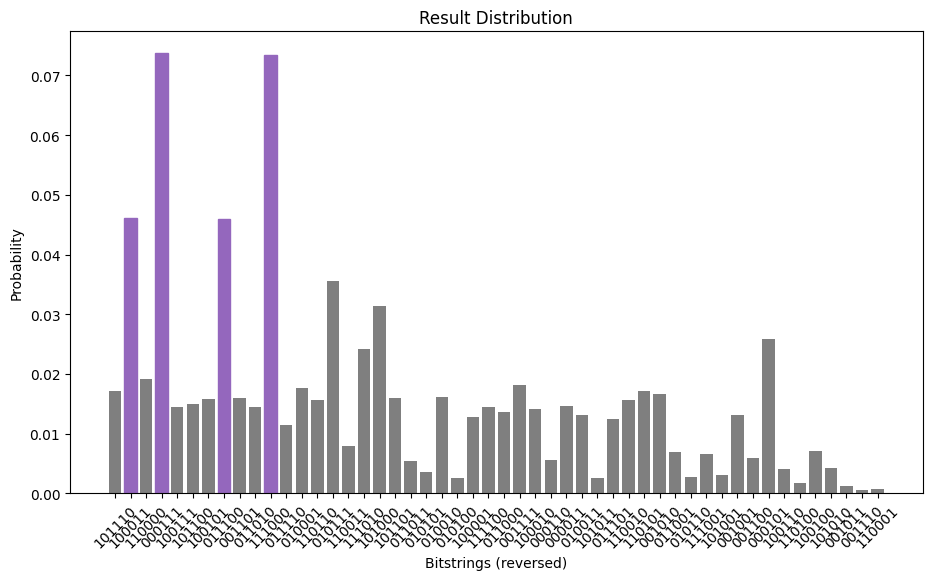

In [113]:
# the probability distribution of bitstring measurements which correspond to the optimal solution
matplotlib.rcParams.update({"font.size": 10})
bits = final_distribution_bin
# Filtered out the invalid bitstrings before plotting or decoding: No trip exceeds 3 patients.
final_bits = {b: c for b, c in bits.items() if 2 <= b.count("1") <= 4}
values = np.abs(list(final_bits.values()))
top_4_values = sorted(values, reverse=True)[:4]
positions = []
for value in top_4_values:
    positions.append(np.where(values == value)[0])
fig = plt.figure(figsize=(11, 6))
ax = fig.add_subplot(1, 1, 1)
plt.xticks(rotation=45)
plt.title("Result Distribution")
plt.xlabel("Bitstrings (reversed)")
plt.ylabel("Probability")
ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
for p in positions:
    ax.get_children()[int(p[0])].set_color("tab:purple")
plt.show()

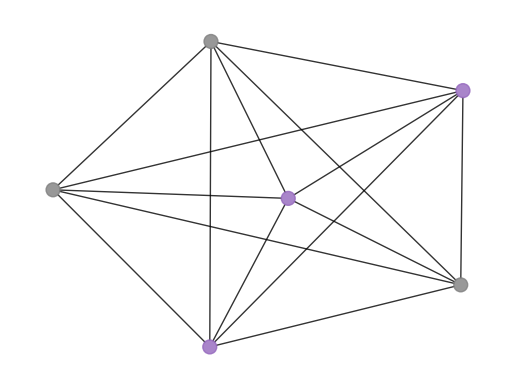

In [114]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, _default_axes = rx.spring_layout(G), plt.axes(frameon=True)
    rx.visualization.mpl_draw(
        G, node_color=colors, node_size=100, alpha=0.8, pos=pos
    )

plot_result(graph, most_likely_bitstring)

In [118]:
# Decode QAOA result
assignments = {0: [], 1: []}
for k, bit in enumerate(most_likely_bitstring[:-1]):
    if bit == 1:
        assignments[0].append(patient_ids[-k-1])
    else:
        assignments[1].append(patient_ids[-k-1])

if len(assignments[0]) == 3:
  assignments['trip 0'] = assignments.pop(0)
  assignments['trip 1'] = assignments.pop(1)
else:
  assignments['trip 0'] = assignments.pop(1)
  assignments['trip 1'] = assignments.pop(0)
assignments

{'trip 0': ['IT', 'R3_2', 'R2'], 'trip 1': ['GR', 'DT']}

In [119]:
# compute costs
id_trip0 = assignments['trip 0']
id_trip1 = assignments['trip 1']

d_p0 = min([d_h[i] for i in assignments['trip 0']])
id_p0 = list(d_h.keys())[list(d_h.values()).index(d_p0)]
if id_p0 in id_trip0:
  id_trip0.remove(id_p0)
d_p1p2 = [d[(id_p0, id_trip0[0])], d[(id_p0, id_trip0[1])]]
d_p2 = d[(id_trip0[0], id_trip0[1])]
if d_p1p2[0] < d_p1p2[1]:
    d_p1 = d_p1p2[0]
    id_p2 = id_trip0[1]
    d_p3 = d_h[id_p2]
else:
    d_p1 = d_p1p2[1]
    id_p2 = id_trip0[0]
    d_p3 = d_h[id_p2]

cost0 = d_p0 + d_p1 + d_p2 + d_p3
cost1 = d_h[id_trip1[0]] + d[(id_trip1[0], id_trip1[1])] + d_h[id_trip1[1]]

trip_costs = {'trip 0':cost0, 'trip 1': cost1}
print(trip_costs)
print(f"Best total distance (km): {sum(trip_costs.values()):.6f}")

{'trip 0': 10.274149770074537, 'trip 1': 13.124447038205815}
Best total distance (km): 23.398597
